In [6]:
#imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [7]:
#reading csv files from download

# df = pd.read_csv('../../../isic-2024-challenge/train-metadata.csv', low_memory=False)

df = pd.read_csv('../../data/data/train-metadata.csv', low_memory=False)

missing_percentages = (df.isnull().sum() / len(df)) * 100
columns_to_keep = missing_percentages[missing_percentages < 50].index
skin_cancer_df = df[columns_to_keep]

features_to_drop = [
    'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    'isic_id', 'patient_id', 'lesion_id', 'attribution', 'copyright_license'
]

skin_cancer_df = skin_cancer_df.drop(columns=[col for col in features_to_drop if col in skin_cancer_df.columns])
skin_cancer_df = skin_cancer_df.fillna(skin_cancer_df.mode().iloc[0])

skin_cancer_df.head()

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence
0,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,...,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,97.517282
1,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,...,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,3.141455
2,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,...,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,99.804040
3,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,...,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,99.989998
4,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,...,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,70.442510


In [8]:
# Label encode all categorical columns
categorical_columns = skin_cancer_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    skin_cancer_df[col] = le.fit_transform(skin_cancer_df[col])

X = skin_cancer_df.drop('target', axis=1)
y = skin_cancer_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Reset indices of X_train and y_train to prevent conflicts during SMOTE
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [9]:

# print(y_train_sm.value_counts())
# print(y_test.value_counts())
# print(set(X_train_sm.index).intersection(set(X_test.index))) 

In [10]:
skin_cancer_decisiontree = DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_split=10,min_samples_leaf=5, random_state=42)


In [11]:
from sklearn.model_selection import cross_val_score
# Perform 5-Fold Cross-Validation
scores = cross_val_score(skin_cancer_decisiontree, X, y, cv=5, scoring='accuracy')

# Print the results
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validation Scores: [0.89022839 0.91630928 0.89976562 0.91725677 0.89962723]
Mean Accuracy: 0.904637459799614
Standard Deviation: 0.01050653809545647


In [12]:
skin_cancer_decisiontree.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [13]:
y_predict = skin_cancer_decisiontree.predict(X_test)

In [14]:
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.8913130204956864


In [15]:
importances = skin_cancer_decisiontree.feature_importances_
feature_names = X.columns
feature_importances = sorted(zip(importances, feature_names), reverse=True)

print(feature_importances)


[(0.48094249524180344, 'tbp_lv_H'), (0.16742841641903738, 'tbp_lv_areaMM2'), (0.1340441648565455, 'clin_size_long_diam_mm'), (0.0971749994571939, 'tbp_lv_dnn_lesion_confidence'), (0.037469122965995534, 'tbp_lv_radial_color_std_max'), (0.013843282282150109, 'tbp_lv_deltaLBnorm'), (0.01148813397544097, 'tbp_lv_minorAxisMM'), (0.010662939402790821, 'tbp_lv_nevi_confidence'), (0.010212203052629602, 'tbp_lv_stdL'), (0.006291539094510752, 'age_approx'), (0.005885391839752191, 'tbp_lv_deltaL'), (0.004636244898903401, 'tbp_lv_B'), (0.004322320974816716, 'tbp_lv_deltaLB'), (0.0042485468088204375, 'tbp_lv_area_perim_ratio'), (0.004000675664594118, 'sex'), (0.0032129259587240326, 'tbp_lv_Bext'), (0.001658603149144679, 'tbp_lv_y'), (0.001205910296360322, 'tbp_lv_x'), (0.0009194799107431537, 'tbp_lv_eccentricity'), (0.00035260375004293883, 'tbp_lv_deltaA'), (0.0, 'tbp_tile_type'), (0.0, 'tbp_lv_z'), (0.0, 'tbp_lv_symm_2axis_angle'), (0.0, 'tbp_lv_symm_2axis'), (0.0, 'tbp_lv_stdLExt'), (0.0, 'tbp_lv

In [16]:
# Evaluate predictions
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_predict))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_predict))

Accuracy: 0.8913130204956864
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     80133
           1       0.01      0.77      0.01        79

    accuracy                           0.89     80212
   macro avg       0.50      0.83      0.48     80212
weighted avg       1.00      0.89      0.94     80212

Confusion Matrix:
[[71433  8700]
 [   18    61]]


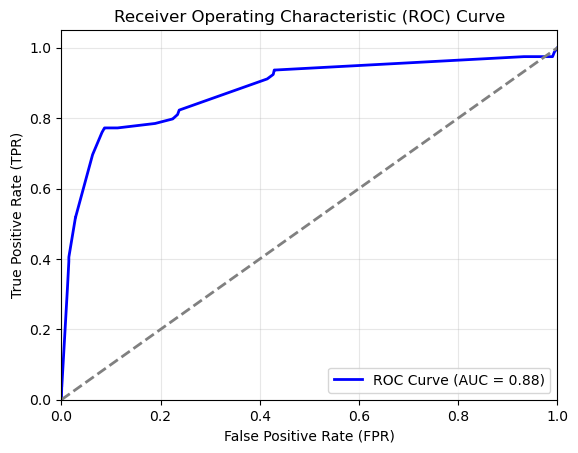

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_prob = skin_cancer_decisiontree.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Decision Tree Structure

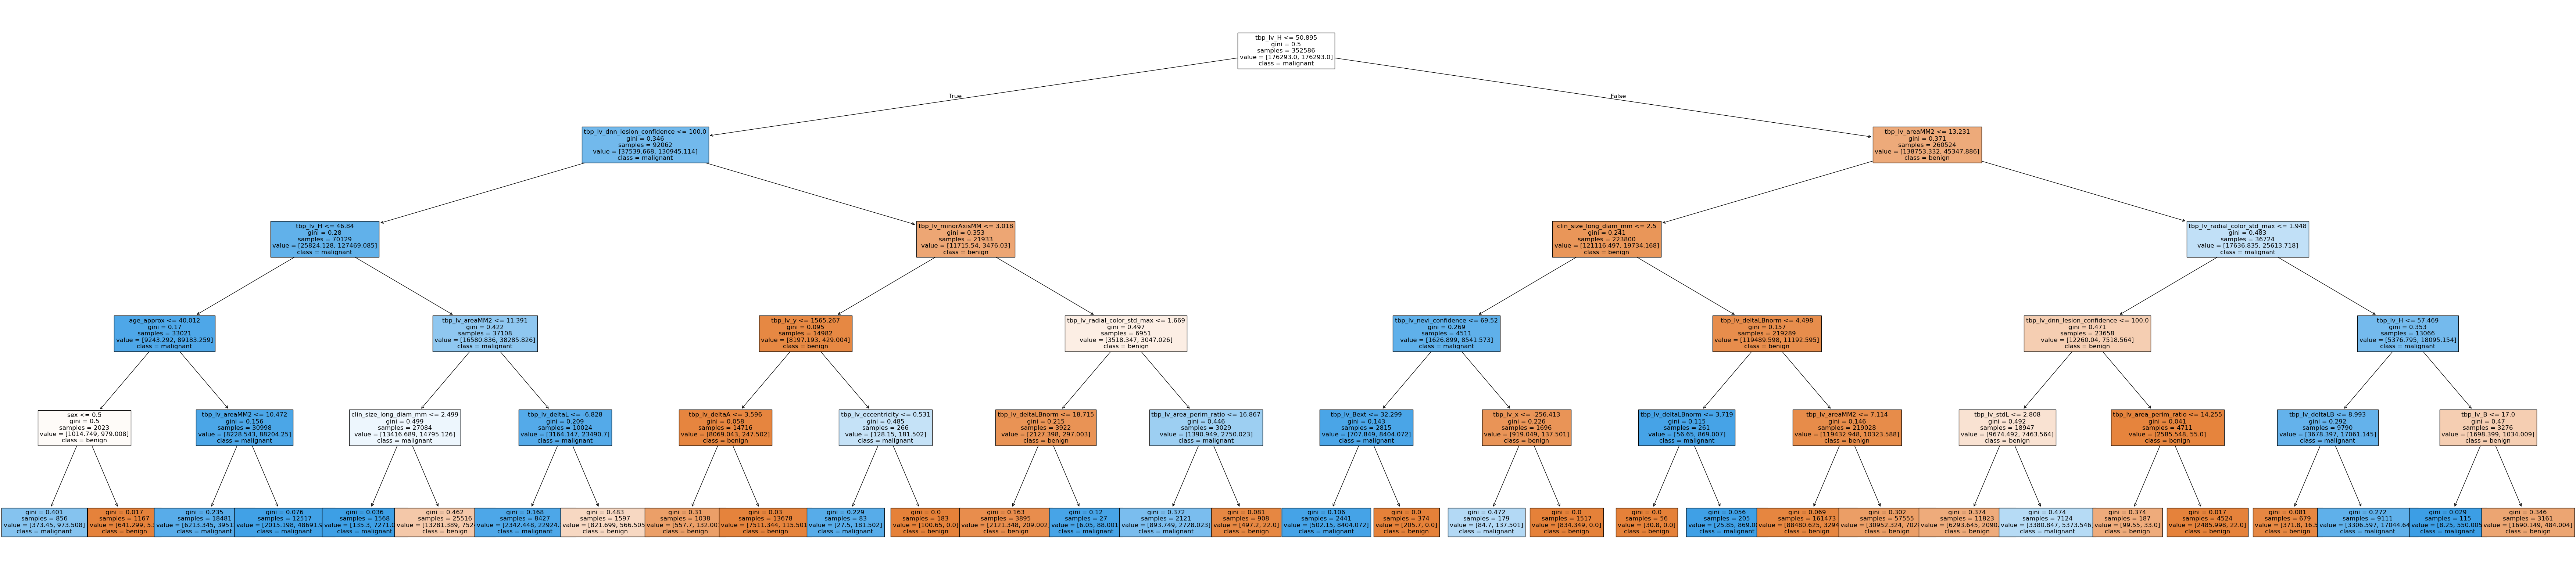

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(90, 20))
plot_tree(skin_cancer_decisiontree, filled=True, feature_names=feature_names, fontsize=12, class_names=['benign', 'malignant'])
plt.show()


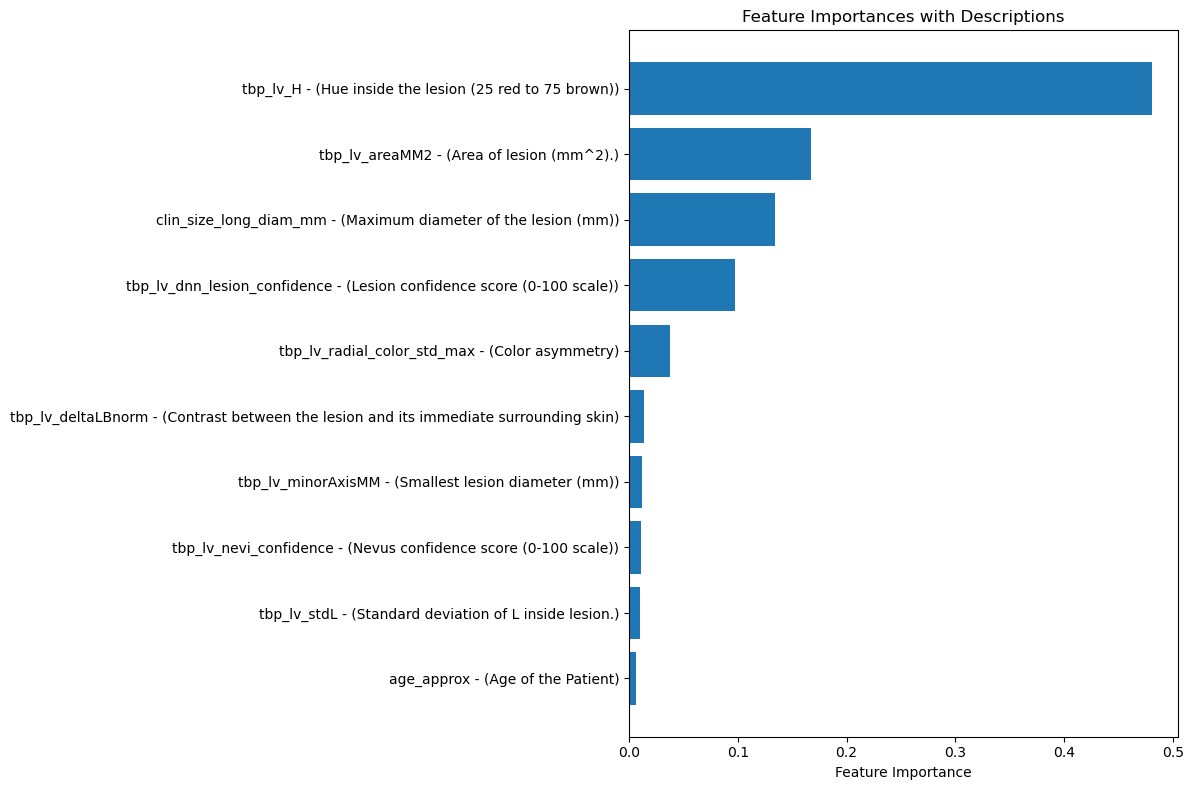

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Updated Mapping of Feature Names to Descriptions
feature_descriptions = {
    "isic_id": "Unique case identifier",
    "patient_id": "Unique patient identifier",
    "age_approx": "Age of the Patient",
    "sex": "Sex of the person",
    "anatom_site_general": "Location of the lesion",
    "clin_size_long_diam_mm": "Maximum diameter of the lesion (mm)",
    "image_type": "Image type",
    "tbp_tile_type": "Lighting modality of the 3D TBP source image.",
    "tbp_lv_A": "A inside lesion",
    "tbp_lv_Aext": "A outside lesion",
    "tbp_lv_B": "B inside lesion",
    "tbp_lv_Bext": "B outside lesion",
    "tbp_lv_C": "Chroma inside lesion",
    "tbp_lv_Cext": "Chroma outside lesion",
    "tbp_lv_H": "Hue inside the lesion (25 red to 75 brown)",
    "tbp_lv_Hext": "Hue outside lesion",
    "tbp_lv_L": "L inside lesion",
    "tbp_lv_Lext": "L outside lesion.",
    "tbp_lv_areaMM2": "Area of lesion (mm^2).",
    "tbp_lv_area_perim_ratio": "Border jaggedness, the ratio between lesions perimeter and area",
    "tbp_lv_color_std_mean": "Color irregularity",
    "tbp_lv_deltaA": "Average A contrast (inside vs. outside lesion).",
    "tbp_lv_deltaB": "Average B contrast (inside vs. outside lesion).",
    "tbp_lv_deltaL": "Average L contrast (inside vs. outside lesion).",
    "tbp_lv_deltaLBnorm": "Contrast between the lesion and its immediate surrounding skin",
    "tbp_lv_eccentricity": "Eccentricity.",
    "tbp_lv_location": "Classification of anatomical location.",
    "tbp_lv_location_simple": "Classification of anatomical location, simple.",
    "tbp_lv_minorAxisMM": "Smallest lesion diameter (mm)",
    "tbp_lv_nevi_confidence": "Nevus confidence score (0-100 scale)",
    "tbp_lv_norm_border": "Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.",
    "tbp_lv_norm_color": "Color variation (0-10 scale)",
    "tbp_lv_perimeterMM": "Perimeter of lesion (mm)",
    "tbp_lv_radial_color_std_max": "Color asymmetry",
    "tbp_lv_stdL": "Standard deviation of L inside lesion.",
    "tbp_lv_stdLExt": "Standard deviation of L outside lesion.",
    "tbp_lv_symm_2axis": "Border asymmetry",
    "tbp_lv_symm_2axis_angle": "Lesion border asymmetry angle.",
    "tbp_lv_x": "X-coordinate of the lesion on 3D TBP.",
    "tbp_lv_y": "Y-coordinate of the lesion on 3D TBP.",
    "tbp_lv_z": "Z-coordinate of the lesion on 3D TBP.",
    "attribution": "Image attribution, synonymous with image source.",
    "copyright_license": "Copyright license.",
    "target": "Binary class {0: benign, 1: malignant}.",
    "lesion_id": "Unique lesion identifier",
    "iddx_full": "Fully classified lesion diagnosis",
    "iddx_1": "First level lesion diagnosis",
    "iddx_2": "Second level lesion diagnosis",
    "iddx_3": "Third level lesion diagnosis",
    "iddx_4": "Fourth level lesion diagnosis",
    "iddx_5": "Fifth level lesion diagnosis",
    "mel_mitotic_index": "Mitotic index of invasive malignant melanomas",
    "mel_thick_mm": "Thickness in depth of melanoma invasion",
    "tbp_lv_dnn_lesion_confidence": "Lesion confidence score (0-100 scale)"
}


top_10 = feature_importances[:10]

top_10.reverse()

graph_data = {}

for importance, feature in top_10:
    feature_descrip = feature_descriptions[feature]
    graph_data[f"{feature} - ({feature_descriptions[feature]})"] = importance
    
 
descriptions = list(graph_data.keys())
importances = list(graph_data.values())

# Set the figure size
plt.figure(figsize=(12, 8))

plt.barh(descriptions, importances)

# Add labels and title
plt.xlabel("Feature Importance")
plt.title("Feature Importances with Descriptions")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


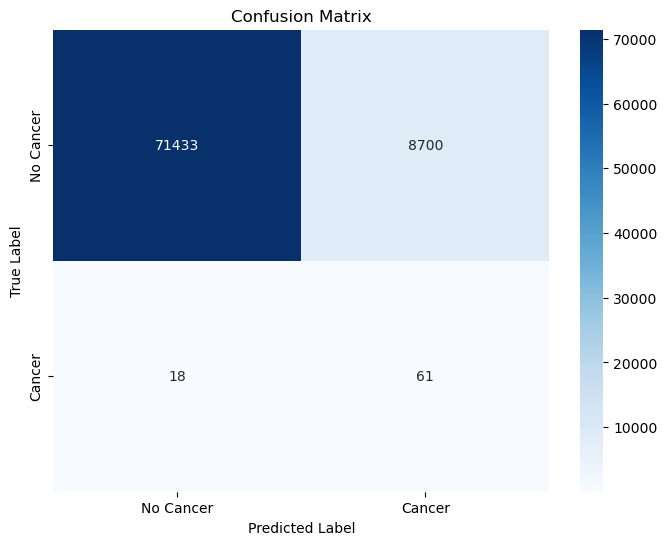

In [20]:
import seaborn as sns
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Cancer', 'Cancer'],
            yticklabels=['No Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

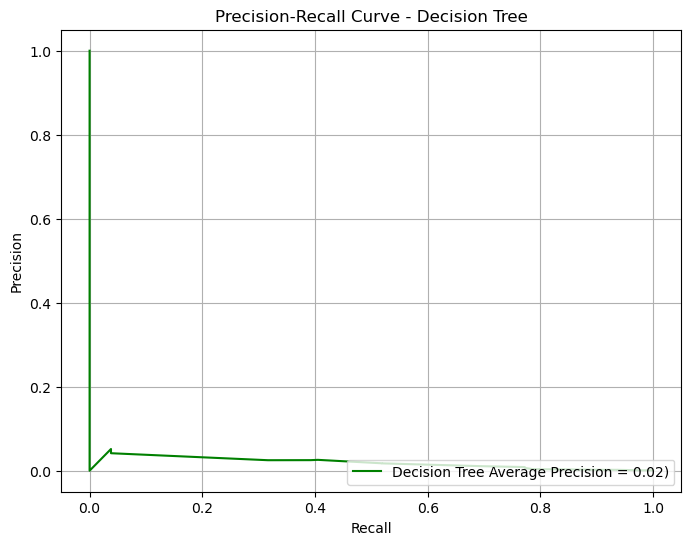

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class from Decision Tree
y_prob_tree = skin_cancer_decisiontree.predict_proba(X_test)[:, 1]  # Positive class probabilities

# Calculate Precision-Recall values
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test, y_prob_tree)

# Calculate the Average Precision Score
avg_precision_tree = average_precision_score(y_test, y_prob_tree)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_tree, precision_tree, color="green", label=f"Decision Tree Average Precision = {avg_precision_tree:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.show()
